## Import dependencies

In [1]:
import io
import os
from urllib.parse import urlparse
import numpy as np
import boto3
import pystac_client
from dotenv import load_dotenv
from PIL import Image
import random
import sys

import sys
import os

notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from src.auth.auth import S3Connector
from src.utils.utils import extract_s3_path_from_url
from src.utils.stac_client import get_product, get_product_content

## Setup and Environment Configuration

First, we'll import the required libraries and set up our environment. Make sure your Copernicus credentials are stored in your environment variables or a `.env` file.


In [2]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
BUCKET_NAME = "eodata"
LON, LAT = 150.97, -20.92

In [3]:
catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
print("Available buckets:", buckets)

Available buckets: ['DIAS', 'EODATA']


In [4]:
# Search for Sentinel-2 products
items_txt = catalog.search(
    collections=['sentinel-2-l2a'],
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<50"]
).item_collection()
selected_item = random.choice(items_txt)
selected_item

<Item id=S2A_MSIL2A_20240501T001111_N0510_R073_T56KKB_20240501T025850>

In [5]:
bucket = s3.Bucket(BUCKET_NAME)
product_url = extract_s3_path_from_url(selected_item.assets['TCI_60m'].href)
file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
                             object_url=product_url,
                             output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)

Successfully downloaded to ./T56KKB_20240501T001111_TCI_60m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/01/S2A_MSIL2A_20240501T001111_N0510_R073_T56KKB_20240501T025850.SAFE/GRANULE/L2A_T56KKB_A046259_20240501T001113/IMG_DATA/R60m/T56KKB_20240501T001111_TCI_60m.jp2


In [6]:
print(f"Successfully downloaded product: {product_url}")
image = Image.open(io.BytesIO(product_content))
resized_image = image.resize((512, 512))
resized_image

Successfully downloaded product: Sentinel-2/MSI/L2A/2024/05/01/S2A_MSIL2A_20240501T001111_N0510_R073_T56KKB_20240501T025850.SAFE/GRANULE/L2A_T56KKB_A046259_20240501T001113/IMG_DATA/R60m/T56KKB_20240501T001111_TCI_60m.jp2


### Random Lon Lat generation

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random
from shapely.geometry import Point
# Load land data
import geodatasets

def get_random_land_point():

    natural_earth_path = geodatasets.get_path("naturalearth.land")
    land = gpd.read_file(natural_earth_path)
    # Select a random land polygon
    random_land = land.sample(1)

    # Get the geometry (polygon or multipolygon)
    geom = random_land.geometry.iloc[0]

    # Find a point within the polygon
    minx, miny, maxx, maxy = geom.bounds

    # Keep trying until we get a point inside the polygon
    while True:
        random_point_x = random.uniform(minx, maxx)
        random_point_y = random.uniform(miny, maxy)
        point = Point(random_point_x, random_point_y)

        if geom.contains(point):
            return random_point_x, random_point_y  # Return lon, lat

# Generate one random point on land
random_lon, random_lat = get_random_land_point()
print(f"Random point on land - Lon: {random_lon}, Lat: {random_lat}")

Random point on land - Lon: 141.16482634949693, Lat: 40.38187453615387


In [8]:
items_txt = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    datetime="2024-05-01/2024-06-01",
).item_collection()
items_txt[0].assets['B02_10m'].href

bucket = s3.Bucket(BUCKET_NAME)
product_url = extract_s3_path_from_url(items_txt[0].assets['B02_10m'].href)
file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
                             object_url=product_url,
                             output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)
image_l2a = Image.open(io.BytesIO(product_content))
resized_image_l2a = image_l2a.resize((512, 512))
resized_image_l2a

Successfully downloaded to ./T56KKB_20240531T001111_B02_10m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/31/S2A_MSIL2A_20240531T001111_N0510_R073_T56KKB_20240531T042453.SAFE/GRANULE/L2A_T56KKB_A046688_20240531T001113/IMG_DATA/R10m/T56KKB_20240531T001111_B02_10m.jp2


/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [9]:
items_txt = catalog.search(
    collections=["sentinel-2-l1c"],
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    datetime="2024-05-01/2024-06-01",
).item_collection()

In [10]:
bucket = s3.Bucket(BUCKET_NAME)
product_url = extract_s3_path_from_url(items_txt[0].assets['B02'].href)
file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
                             object_url=product_url,
                             output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)
image_l1c = Image.open(io.BytesIO(product_content))
resized_image_l1c = image_l1c.resize((512, 512))
resized_image_l1c

Successfully downloaded to ./T56KKB_20240531T001111_B02.jp2
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/31/S2A_MSIL1C_20240531T001111_N0510_R073_T56KKB_20240531T031506.SAFE/GRANULE/L1C_T56KKB_A046688_20240531T001113/IMG_DATA/T56KKB_20240531T001111_B02.jp2


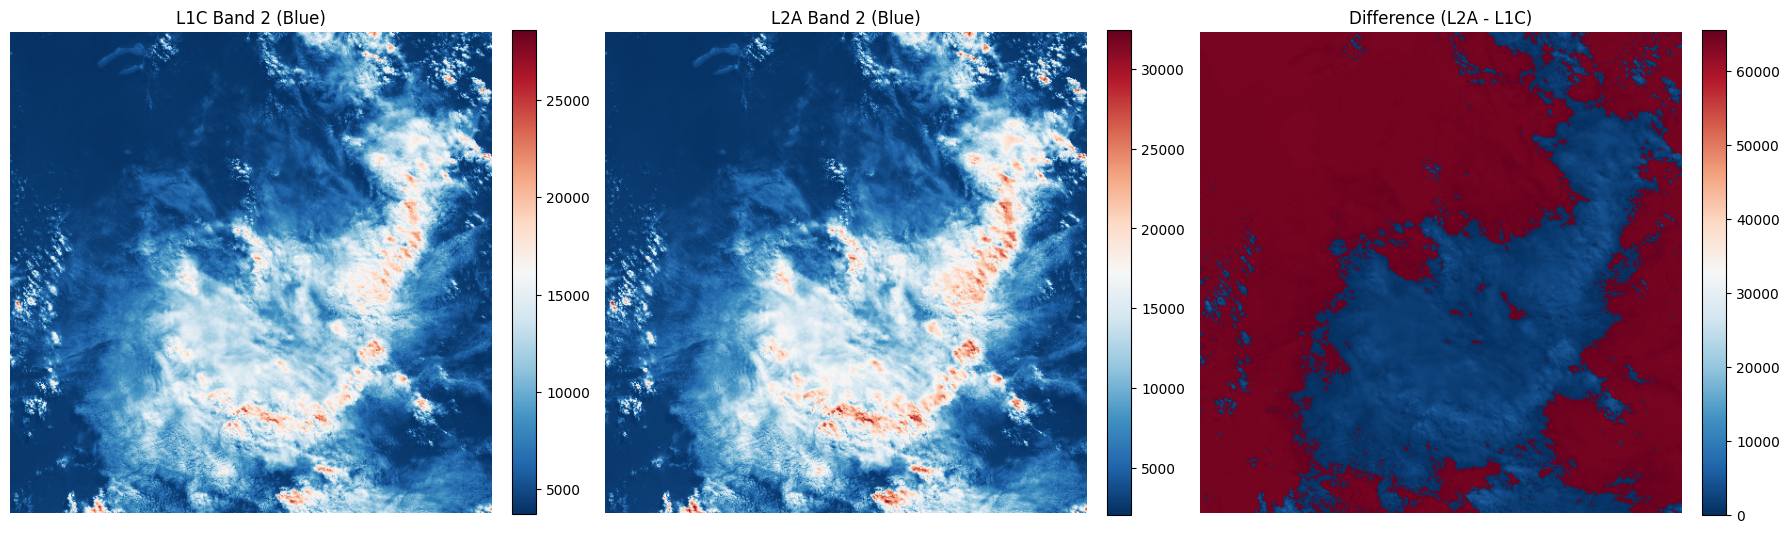

In [11]:

resized_image_l1c = np.array(resized_image_l1c)
resized_image_l2a = np.array(resized_image_l2a)
# Calculate the difference
difference = np.abs(resized_image_l2a - resized_image_l1c)


# Visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Display L1C
im1 = ax[0].imshow(resized_image_l1c, cmap='RdBu_r')
ax[0].set_title('L1C Band 2 (Blue)')
ax[0].axis('off')
plt.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)
# Display L2A
im2 = ax[1].imshow(resized_image_l2a, cmap='RdBu_r')
ax[1].set_title('L2A Band 2 (Blue)')
ax[1].axis('off')
plt.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

im3 = ax[2].imshow(difference, cmap='RdBu_r')
ax[2].set_title('Difference (L2A - L1C)')
ax[2].axis('off')
plt.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [12]:
def linear_stretch_to_uint8(band, lower_percent=2, upper_percent=98):
    """
    Apply a linear 2% stretch and convert to uint8 (0-255).
    This is a standard enhancement for remote sensing imagery.
    """
    # Calculate percentiles
    p_low = np.nanpercentile(band, lower_percent)
    p_high = np.nanpercentile(band, upper_percent)
    # Apply linear stretch and convert to uint8
    stretched = np.clip((band - p_low) / (p_high - p_low) * 255, 1, 255).astype(np.uint8)
    return stretched

In [13]:
bands = { 1: 'B02', 2: 'B03', 3: 'B04'}
# bands = { 1: 'B02_60m', 2: 'B03_60m', 3: 'B04_60m'}

# Loop through each band
band_data = {}
band_arrays = {}
for band_index, band_name in bands.items():
    print(f"Band {band_index}: {band_name}")
    product_url = extract_s3_path_from_url(items_txt[0].assets[band_name].href)
    # file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
    #                             object_url=product_url,
    #                             output_path=".")
    product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)
    band_data[band_name] = product_content
    product_content = Image.open(io.BytesIO(product_content))
    product_content = np.array(product_content)
    band_arrays[band_name] = product_content

Band 1: B02
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/31/S2A_MSIL1C_20240531T001111_N0510_R073_T56KKB_20240531T031506.SAFE/GRANULE/L1C_T56KKB_A046688_20240531T001113/IMG_DATA/T56KKB_20240531T001111_B02.jp2
Band 2: B03
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/31/S2A_MSIL1C_20240531T001111_N0510_R073_T56KKB_20240531T031506.SAFE/GRANULE/L1C_T56KKB_A046688_20240531T001113/IMG_DATA/T56KKB_20240531T001111_B03.jp2
Band 3: B04
Successfully downloaded Sentinel-2/MSI/L1C/2024/05/31/S2A_MSIL1C_20240531T001111_N0510_R073_T56KKB_20240531T031506.SAFE/GRANULE/L1C_T56KKB_A046688_20240531T001113/IMG_DATA/T56KKB_20240531T001111_B04.jp2


In [14]:
# Create RGB composite
rgb_array = np.stack([
    linear_stretch_to_uint8(band_arrays['B04']),  # Red
    linear_stretch_to_uint8(band_arrays['B03']),  # Green
    linear_stretch_to_uint8(band_arrays['B02'])   # Blue
], axis=2)

In [ ]:
# # Convert to PIL image
# rgb_image = Image.fromarray(rgb_array)
# rgb_image